In [381]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json
from matplotlib import pyplot as plt
import seaborn as sns

dataframes = ["TheftEvent.parquet", "VisionEvent.parquet", "MapEvent.parquet", "ChosenTargetEvent.parquet"]
attach_config_vars = ["generation_empty_w"]

folder = Path(".").resolve() / "data" / "experiments"
regex = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(\d{5})"


def load_experiments_by_name(name) -> dict[str, pd.DataFrame]:

    dfs = {dfname: [] for dfname in dataframes}

    for ent in (folder / name).iterdir():

        if not ent.is_dir():
            continue

        res = re.match(regex, ent.name)
        
        if res is None:
            continue

        dstr, randstr = res.group(1), res.group(2)

        if not (ent / "config.json").is_file():
            continue

        with open(ent / "config.json", "r", encoding="utf-8") as f:
            config = json.load(f)
        
        skip_log = not all([(ent / dfname).is_file() for dfname in dataframes])
    
        if skip_log:
            continue

        for dfname in dataframes:
            df = pd.read_parquet(ent / dfname) 
            df["rand"]= ent.name
            
            for av in attach_config_vars:
                df[av] = config[av]
            
            dfs[dfname].append(df)

        

    
    dfs = {dfname: pd.concat(inners, ignore_index=True) for dfname, inners in dfs.items()}

    return dfs

dfs = load_experiments_by_name("look_for_target_cooldown")
df = dfs["TheftEvent.parquet"]
vision = dfs["VisionEvent.parquet"]
walls_df = dfs["MapEvent.parquet"]
ts = dfs["ChosenTargetEvent.parquet"]

In [382]:
df.groupby("rand").size()

rand
2024-10-03_14-59-19_11882    111
2024-10-03_14-59-19_35771     95
2024-10-03_14-59-19_40120    110
2024-10-03_14-59-19_54848    116
2024-10-03_14-59-19_61982     97
                            ... 
2024-10-03_15-01-52_44857    114
2024-10-03_15-01-52_61890    100
2024-10-03_15-01-52_82300    118
2024-10-03_15-01-52_96012     99
2024-10-03_15-01-53_16243    101
Length: 120, dtype: int64

In [383]:



def custom():
    cubes = []
    walls = []
    empty_w = []

    for rand in vision["rand"].unique():
        df = vision[vision["rand"] == rand]
        var_interest = df["generation_empty_w"]

        if (uniques := var_interest.unique()).size > 1:
            raise ValueError("Var unique more than 1")
        
        empty_w.append(uniques[0])

        walls_one_df = walls_df[walls_df["rand"] == rand].drop(columns=["rand", "generation_empty_w"])
        walls.append(walls_one_df.to_numpy())
        
        df = df.drop(columns=["rand", "generation_empty_w"])
        n_grid = df.columns.size - 1
        n_time = df["t"].unique().size
        
        cube_data = df.drop(columns="t")
        cube = np.empty((n_time, n_grid, n_grid))

        for t in range(n_time):
            offset = t * n_grid
            
            cube[t, :, :] = cube_data.iloc[offset:offset+n_grid, :].to_numpy()
    
        cubes.append(cube)

    return np.array(cubes), np.array(empty_w), np.array(walls)

cubes, empty_w, walls = custom()
cubes.shape, walls.shape

((120, 140, 24, 24), (120, 24, 24))

Text(0.5, 0, 'empty_w')

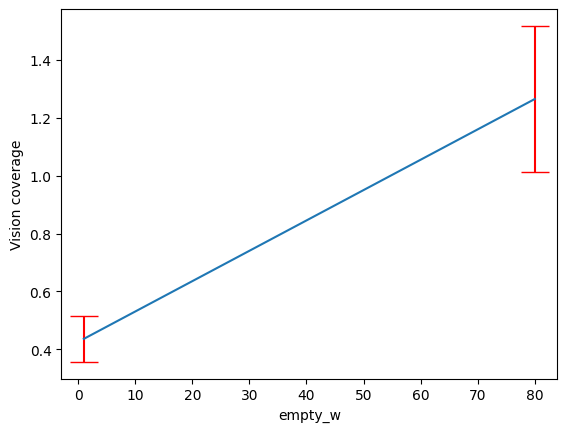

In [384]:
X = np.unique(empty_w)

iv = {"empty_w": [], "v_mean": [], "v_std": []}
for x in X:
    mask = empty_w == x
    group_cubes = cubes[mask, :, :, :]
    group_walls = walls[mask, :, :]

    n_var, n_time, N, _ = group_cubes.shape
    n_per_var = n_time * N * N

    mean_vis = []
    for i_var in range(n_var):
        n_walls = np.isclose(group_walls[i_var], 0.0).sum()
        n_valid = n_per_var - (n_walls * n_time)
        sum_vision = np .sum(group_cubes[i_var, :, :, :])
        mean_vis.append(sum_vision / n_valid)

    iv["empty_w"].append(x)
    iv["v_mean"].append(np.mean(mean_vis))
    iv["v_std"].append(np.std(mean_vis))


iv = pd.DataFrame(iv).sort_values("empty_w")
x = iv["empty_w"]
y = iv["v_mean"]
err = iv["v_std"]

fig, ax = plt.subplots()

#ax.plot(x, y)
ax.errorbar(x, y, err, capsize=10, ecolor="red")
ax.set_ylabel("Vision coverage")
ax.set_xlabel("empty_w")

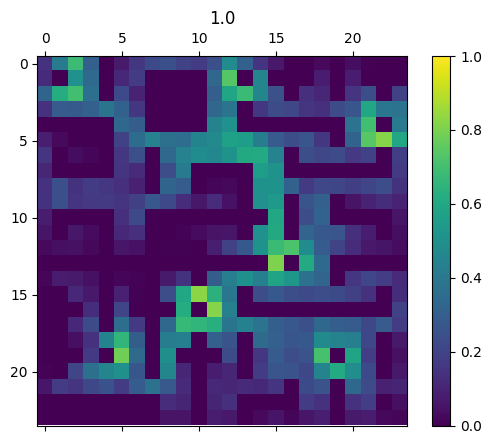

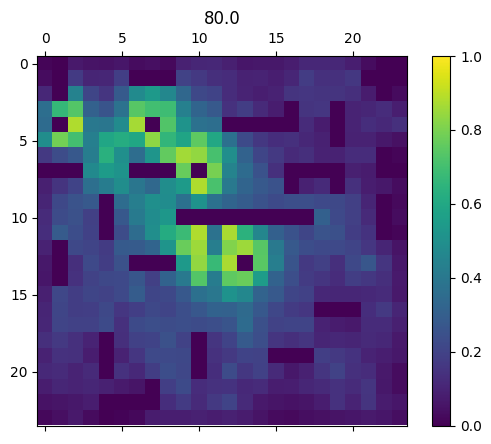

In [385]:
from scipy.signal import convolve2d

def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

# Create a 5x5 Gaussian kernel with sigma = 1
gaussian_filter = gaussian_kernel(7, 0.7)

X = np.unique(empty_w)

for x in X:
    mask = empty_w == x
    cube = cubes[mask, :, :, :]
    cube = cube[np.random.randint(cube.shape[0]), :, :, :]
    # cube = cube[0, :, :, :]
    cube = np.mean(cube, axis=0)
    #cube = convolve2d(cube, gaussian_filter, mode="same", boundary="symm")

    fig, ax = plt.subplots()
    ax.set_title(x)
    mappable = ax.matshow(cube, vmin=0, vmax=1)
    fig.colorbar(mappable)
    plt.show()

Text(0, 0.5, 'N of thefts')

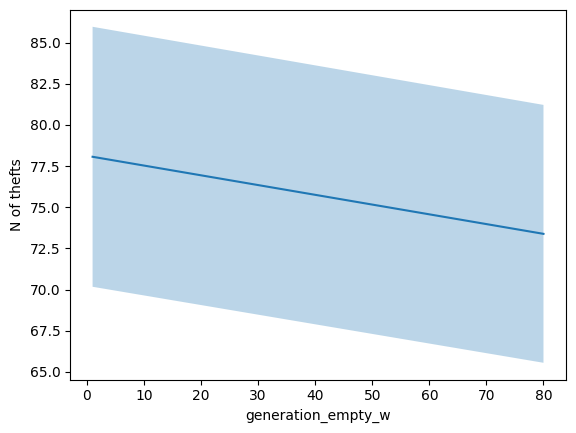

In [386]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")

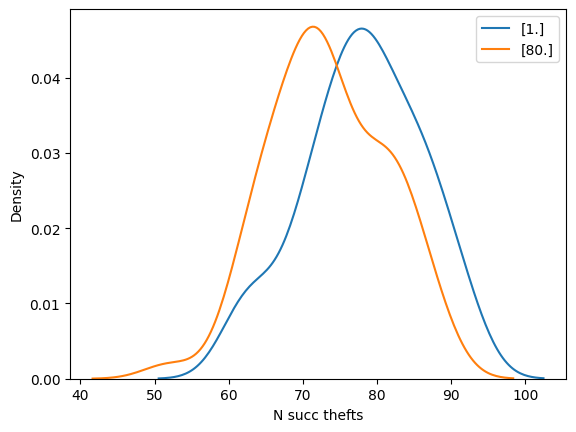

In [396]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

fig, ax = plt.subplots()

g.groupby("generation_empty_w").apply(lambda df: sns.kdeplot(df["count"], ax=ax, label=df["generation_empty_w"].unique()))

ax.set_xlabel("N succ thefts")
ax.legend()
plt.show()

In [397]:
g

,rand,generation_empty_w,caught,count
0,2024-10-03_14-59-19_11882,1.0,False,77
2,2024-10-03_14-59-19_35771,1.0,False,62
4,2024-10-03_14-59-19_40120,1.0,False,83
6,2024-10-03_14-59-19_54848,1.0,False,84
8,2024-10-03_14-59-19_61982,1.0,False,68
...,...,...,...,...
230,2024-10-03_15-01-52_44857,80.0,False,71
232,2024-10-03_15-01-52_61890,80.0,False,75
234,2024-10-03_15-01-52_82300,80.0,False,81
236,2024-10-03_15-01-52_96012,80.0,False,66


In [400]:
from scipy.stats import ttest_ind 

densities = np.sort(g["generation_empty_w"].unique())
value_high_dens = densities[-1]
value_low_dens = densities[0]
sample_high_dens = g[g["generation_empty_w"] == value_high_dens]["count"]
sample_low_dens = g[g["generation_empty_w"] == value_low_dens]["count"]
ttest_ind(sample_low_dens, sample_high_dens, equal_var=False, alternative="greater")

TtestResult(statistic=3.260459393517335, pvalue=0.0007270346998443582, df=117.99215658757959)

<Axes: xlabel='generation_empty_w'>

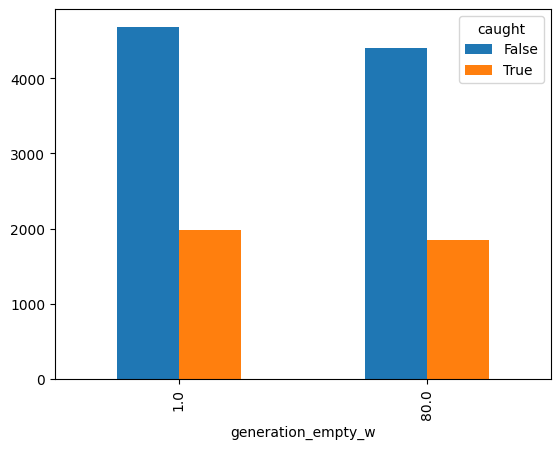

In [388]:
caught = df[df["caught"]]

df.groupby(interest)["caught"].value_counts().unstack().plot.bar()

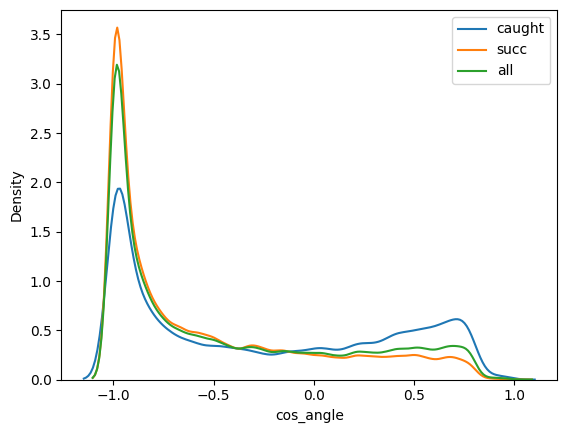

In [389]:
fig, ax = plt.subplots()

sns.kdeplot(df.loc[df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="caught")
sns.kdeplot(df.loc[~df["caught"], "cos_angle"], bw_adjust=0.4, ax=ax, label="succ")
sns.kdeplot(df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label="all")

ax.legend()
plt.show()

In [390]:
ts["motivation"].describe()

count    18767.000000
mean         0.734665
std          0.189952
min          0.500000
25%          0.563661
50%          0.706412
75%          0.941997
max          1.000000
Name: motivation, dtype: float64

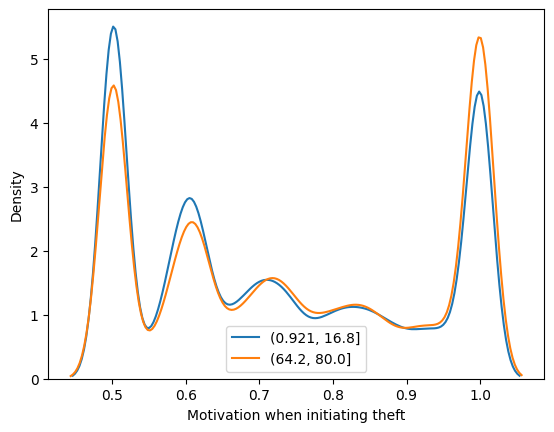

In [391]:
fig, ax = plt.subplots()


ts["w_empty_bin"] = pd.cut(ts[interest], bins=5)

for interval in ts["w_empty_bin"].unique():
    empty_bin_df = ts[ts["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "motivation"], bw_adjust=0.6, ax=ax, label=str(interval))

ax.set_xlabel("Motivation when initiating theft")
ax.legend()
plt.show()

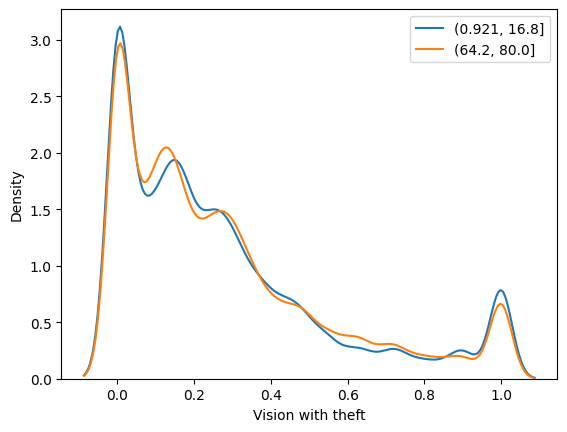

In [392]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "vision"], bw_adjust=0.6, ax=ax, label=str(interval))

ax.set_xlabel("Vision with theft")
ax.legend()
plt.show()

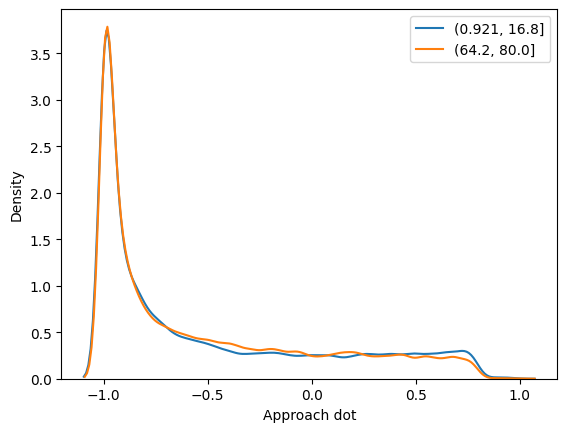

In [236]:
fig, ax = plt.subplots()


df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    sns.kdeplot(empty_bin_df.loc[:, "cos_angle"], bw_adjust=0.4, ax=ax, label=str(interval))

ax.set_xlabel("Approach dot")
ax.legend()
plt.show()

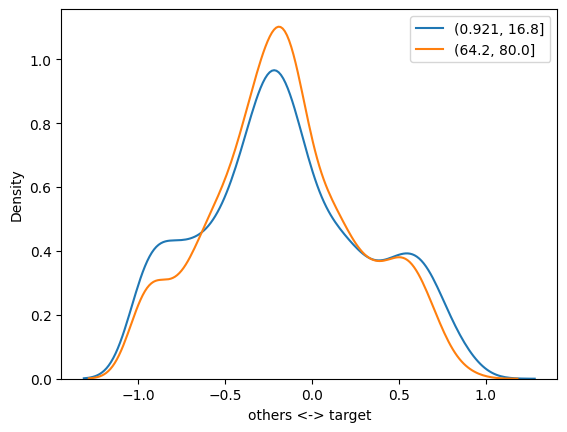

In [394]:
fig, ax = plt.subplots()

df["w_empty_bin"] = pd.cut(df[interest], bins=5)

for interval in df["w_empty_bin"].unique():
    empty_bin_df = df[df["w_empty_bin"] == interval]
    caught = empty_bin_df[empty_bin_df["caught"]].copy()
    caught["p_target"] = caught["cos_angle"] / 2 + 0.5
    caught["p_other"] = caught["vision"]

    caught["others <-> target"] = caught["p_target"] - caught["p_other"]

    sns.kdeplot(caught["others <-> target"], ax=ax, label=str(interval))

ax.legend()